In [1]:
import sys
import os
import time
import codecs
import pandas as pd

sys.path.append("/Users/Bya/git/predictEPL/utils/")
sys.path.append("/Users/Bya/git/predictEPL/config/")

import emolex
import paths
import tokenizer
import useful_methods as my_methods
import train_datas

In [2]:
%pylab inline
%matplotlib inline

import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import pickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

Populating the interactive namespace from numpy and matplotlib


### Step 1: Load Data, look around

In [3]:
dic_emolex_soccer, y = emolex.EmolexSoccerDic()

All Words: 14152


In [4]:
# Read Hash Emolex CSV
dfHashEmolex = train_datas.HashEmolexAllRead()

# Labeling Emolex 8 cat => POS, NEG
texts = []
sentiments = []

for i in range(len(dfHashEmolex)):
    text = dfHashEmolex.iloc[i]['text']
    sentiment = dfHashEmolex.iloc[i]['sentiments'].split(',')
    
    for sent in sentiment:
        if sent in ['anger', 'disgust', 'fear', 'sadness', 'negative']:
            texts.append(text)
            sentiments.append(0) # 0 is negative
            break

        elif sent in ['anticipation', 'joy', 'positive', 'trust']:
            texts.append(text)
            sentiments.append(1) # 1 is negative
            break

# Create New POS, NEG dataframe
dfTwitter = pd.DataFrame(columns=['tweet', 'sentiment'])
dfTwitter['tweet'] = texts
dfTwitter['sentiment'] = sentiments

In [5]:
# POS vs NEG
dfTwitter.groupby('sentiment').describe()

tweet
sentiment                                                          
0         count                                                5958
          unique                                               5743
          top     #Earn 1K-2K monthly #risk free #bookiebashing....
          freq                                                    5
1         count                                                4946
          unique                                               4403
          top     Make 2k monthly #Bookiebashing with #Freebets ...
          freq                                                    9

In [6]:
# Adding 'length' column
dfTwitter['length'] = [len(text) for text in dfTwitter['tweet']]
dfTwitter.head()

,tweet,sentiment,length
0,#body #status Dewibet Jkt - Susunan Pemain… h...,1,130
1,BRILLIANT!!!!! @Mo_Farah Simply the best!!!!! ...,1,86
2,@markvanhartenn yesss #NUFC #Arsenal #HYPE,1,42
3,#fuck #chelsea #love #arsenal http://t.co/EmNX...,1,52
4,Watching both #Arsenal &amp; #DerbyCounty #Foo...,0,105


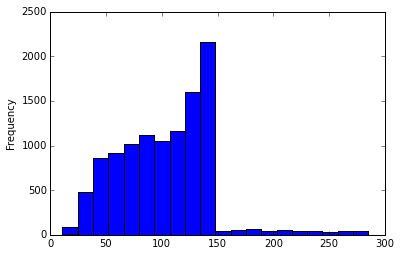

In [7]:
dfTwitter.length.plot(bins=20, kind='hist')

In [8]:
dfTwitter.length.describe()

count    10904.000000
mean       102.615829
std         41.641272
min         11.000000
25%         70.000000
50%        105.000000
75%        134.000000
max        285.000000
Name: length, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1147c26a0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x10f330b38>], dtype=object)

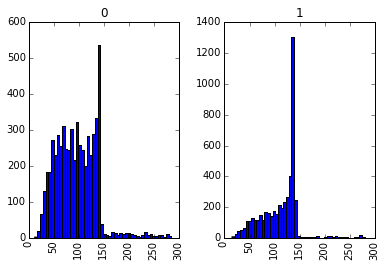

In [9]:
# Tweet Length: POS vs NEG 
dfTwitter.hist(column='length', by='sentiment', bins=50)

### Step 2: Data Preprocessing

In [10]:
# Text to Words
def split_into_tokens(text):
    return TextBlob(text).words

In [11]:
dfTwitter.tweet.head()

0    #body #status Dewibet Jkt -  Susunan Pemain… h...
1    BRILLIANT!!!!! @Mo_Farah Simply the best!!!!! ...
2           @markvanhartenn yesss #NUFC #Arsenal #HYPE
3    #fuck #chelsea #love #arsenal http://t.co/EmNX...
4    Watching both #Arsenal &amp; #DerbyCounty #Foo...
Name: tweet, dtype: object

In [12]:
dfTwitter.tweet.head().apply(split_into_tokens)

0    [body, status, Dewibet, Jkt, Susunan, Pemain…,...
1    [BRILLIANT, Mo_Farah, Simply, the, best, World...
2         [markvanhartenn, yesss, NUFC, Arsenal, HYPE]
3    [fuck, chelsea, love, arsenal, http, t.co/EmNX...
4    [Watching, both, Arsenal, amp, DerbyCounty, Fo...
Name: tweet, dtype: object

In [13]:
# Applying TweetLemmaSoccer
dfTwitter.tweet.head().apply(tokenizer.TweetLemmaSoccer)

0    [body, status, dewibet, jkt, susunan, pemain…,...
1    [brilliant, mo_farah, simply, best, worldchamp...
2           [markvanhartenn, yes, nufc, arsenal, hype]
3                       [fuck, chelsea, love, arsenal]
4    [watching, arsenal, amp, derbycounty, saturday...
Name: tweet, dtype: object

### Step 3: Data to Vectors

In [14]:
%time bow_transformer = CountVectorizer(analyzer=tokenizer.TweetLemmaSoccer).fit(dfTwitter['tweet'])
# unique words
print(len(bow_transformer.vocabulary_))

CPU times: user 12.8 s, sys: 463 ms, total: 13.2 s
Wall time: 13.5 s
13881


In [15]:
# Let's take one text message and get its bag-of-words counts as a vector,
# putting to use our new bow_transformer:

tweet1 = dfTwitter['tweet'][1]
print(tweet1)

BRILLIANT!!!!! @Mo_Farah Simply the best!!!!! #WorldChampion #Athlete #Gooner #Arsenal


In [16]:
bow1 = bow_transformer.transform([tweet1])
print(bow1)
print(bow1.shape)

  (0, 1457)	1
  (0, 1568)	1
  (0, 1944)	1
  (0, 2344)	1
  (0, 5457)	1
  (0, 7970)	1
  (0, 10814)	1
  (0, 13143)	1
(1, 13881)


In [17]:
print(bow_transformer.get_feature_names()[1457])
print(bow_transformer.get_feature_names()[1568])

arsenal
athlete


In [18]:
# The bag-of-words counts for the entire Tweets corpus are a large,
# sparse matrix:

tweets_bow = bow_transformer.transform(dfTwitter['tweet'])
print('sparse matrix shape:', tweets_bow.shape)
print('number of non-zeros:', tweets_bow.nnz)
print('sparsity: %.2f%%' % (100.0 * tweets_bow.nnz / (tweets_bow.shape[0] * tweets_bow.shape[1])))

sparse matrix shape: (10904, 13881)
number of non-zeros: 110518
sparsity: 0.07%


In [19]:
# And finally, after the counting,
# the term weighting and normalization can be done with TF-IDF,
# using scikit-learn's TfidfTransformer:

tfidf_transformer = TfidfTransformer().fit(tweets_bow)
tfidf1 = tfidf_transformer.transform(bow1)
print(tfidf1)

  (0, 13143)	0.440691745586
  (0, 10814)	0.322993695042
  (0, 7970)	0.440691745586
  (0, 5457)	0.398645834403
  (0, 2344)	0.269180980132
  (0, 1944)	0.237924028676
  (0, 1568)	0.440691745586
  (0, 1457)	0.158311984085


In [20]:
# What is the IDF (inverse document frequency) of the
# word: "fun"? Of word: "go"?

print(tfidf_transformer.idf_[bow_transformer.vocabulary_['goal']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['shit']])

3.77930540572
4.78758834201


In [21]:
# To transform the entire bag-of-words corpus into TF-IDF corpus at once:

tweets_tfidf = tfidf_transformer.transform(tweets_bow)
print(tweets_tfidf.shape)

(10904, 13881)


### Step 4: Training a model and, classifying sentiment

In [22]:
%time sentiment_detector = MultinomialNB().fit(tweets_tfidf, dfTwitter['sentiment'])

CPU times: user 6.57 ms, sys: 1.58 ms, total: 8.15 ms
Wall time: 7.28 ms


In [23]:
# Let's try classifying our single random review:

print(dfTwitter.tweet[1], "\n")
print('predicted:', sentiment_detector.predict(tfidf1)[0])
print('expected:', dfTwitter.sentiment[1])

BRILLIANT!!!!! @Mo_Farah Simply the best!!!!! #WorldChampion #Athlete #Gooner #Arsenal 

predicted: 1
expected: 1


In [24]:
# How many messages do we classify correctly overall?

all_predictions = sentiment_detector.predict(tweets_tfidf)
print(all_predictions)

[1 1 1 ..., 0 1 0]


In [25]:
print('accuracy', accuracy_score(dfTwitter['sentiment'], all_predictions))
print('confusion matrix\n', confusion_matrix(dfTwitter['sentiment'], all_predictions))
print('(row=expected, col=predicted)')

accuracy 0.891507703595
confusion matrix
 [[5856  102]
 [1081 3865]]
(row=expected, col=predicted)


/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


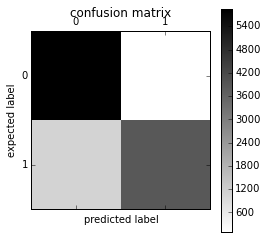

In [26]:
plt.matshow(confusion_matrix(dfTwitter['sentiment'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [27]:
# From this confusion matrix, we can compute:
# precision and recall, or their combination (harmonic mean) F1:

print(classification_report(dfTwitter['sentiment'], all_predictions))

             precision    recall  f1-score   support

          0       0.84      0.98      0.91      5958
          1       0.97      0.78      0.87      4946

avg / total       0.90      0.89      0.89     10904



### Step 5: How to run expirements?

A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is never used in any way -- thanks to this process, we make sure we are not "cheating", and that our final evaluation on test data is representative of true predictive performance.

In [28]:
tweets_train, tweets_test, sentiment_train, sentiment_test = \
    train_test_split(dfTwitter['tweet'], dfTwitter['sentiment'], test_size=0.2)

print(len(tweets_train), len(tweets_test), len(sentiment_train) + len(sentiment_test))


8723 2181 10904


In [50]:
# Let's recap the entire pipeline up to this point,
# putting the steps explicitly into scikit-learn's Pipeline:

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=tokenizer.TweetLemmaSoccer)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

A common practice is to partition the training set again, into smaller subsets; for example, 5 equally sized subsets. Then we train the model on four parts, and compute accuracy on the last part (called "validation set"). Repeated five times (taking different part for evaluation each time), we get a sense of model "stability". If the model gives wildly different scores for different subsets, it's a sign something is wrong (bad data, or bad model variance). Go back, analyze errors, re-check input data for garbage, re-check data cleaning.

In [51]:
# In our case, everything goes smoothly though:

scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         tweets_train,  # training data
                         sentiment_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print(scores)

[ 0.84306987  0.84421535  0.84879725  0.82683486  0.81192661  0.84633028
  0.83486239  0.84174312  0.82798165  0.81422018]


In [31]:
print(scores.mean(), scores.std())

0.83399815568 0.0125870785759


Naive Bayes is an example of a high bias - low variance classifier (aka simple and stable, not prone to overfitting). An example from the opposite side of the spectrum would be Nearest Neighbour (kNN) classifiers, or Decision Trees, with their low bias but high variance (easy to overfit). Bagging (Random Forests) as a way to lower variance, by training many (high-variance) models and averaging.

In other words:

* **high bias** = classifer is opinionated. Not as much room to change its mind with data, it has its own ideas. On the other hand, not as much room it can fool itself into overfitting either (picture on the left).
* **low bias** = classifier more obedient, but also more neurotic. Will do exactly what you ask it to do, which, as everybody knows, can be a real nuisance (picture on the right).

In [32]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

CPU times: user 470 ms, sys: 104 ms, total: 574 ms
Wall time: 2min 2s


<module 'matplotlib.pyplot' from '/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/pyplot.py'>

/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


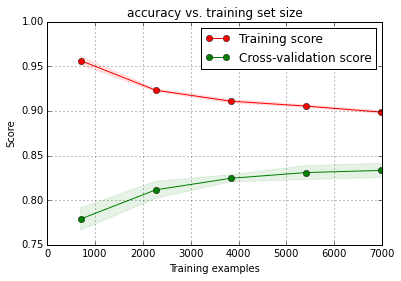

In [33]:
%time plot_learning_curve(pipeline, "accuracy vs. training set size", tweets_train, sentiment_train, cv=5)

### Step 6: How to tune Parameters?

What we've seen so far is only a tip of the iceberg: there are many other parameters to tune. One example is what algorithm to use for training.

We've used Naive Bayes above, but scikit-learn supports many classifiers out of the box: Support Vector Machines, Nearest Neighbours, Decision Trees, Ensamble methods...

[We can ask]: What is the effect of IDF weighting on accuracy? Does the extra processing cost of lemmatization (vs. just plain words) really help?

Let's find out:

In [34]:
params = {
    'tfidf__use_idf': (True, False),
    'bow__analyzer': (tokenizer.TweetLemmaSoccer, tokenizer.TweetLemmaSoccerNeg),
}

grid = GridSearchCV(
    pipeline,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(sentiment_train, n_folds=5),  # what type of cross validation to use
)

In [35]:
%time nb_detector = grid.fit(tweets_train, sentiment_train)
print(nb_detector.grid_scores_)

CPU times: user 11.3 s, sys: 334 ms, total: 11.6 s
Wall time: 1min 51s
[mean: 0.83331, std: 0.00792, params: {'tfidf__use_idf': True, 'bow__analyzer': <function TweetLemmaSoccer at 0x11399d0d0>}, mean: 0.82586, std: 0.00598, params: {'tfidf__use_idf': False, 'bow__analyzer': <function TweetLemmaSoccer at 0x11399d0d0>}, mean: 0.83469, std: 0.00801, params: {'tfidf__use_idf': True, 'bow__analyzer': <function TweetLemmaSoccerNeg at 0x11399e400>}, mean: 0.82793, std: 0.00606, params: {'tfidf__use_idf': False, 'bow__analyzer': <function TweetLemmaSoccerNeg at 0x11399e400>}]


In [36]:
nb_detector.best_score_

0.83468990026367074

In [37]:
nb_detector.best_params_

{'bow__analyzer': <function tokenizer.TweetLemmaSoccerNeg>,
 'tfidf__use_idf': True}

In [38]:
nb_detector.best_estimator_

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function TweetLemmaSoccerNeg at 0x11399e400>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [48]:
# A quick sanity check:
%time print(nb_detector.predict_proba(["did not wonderful"])[0])
%time print(nb_detector.predict_proba(["Hi mom, how are you?"])[0])
%time print(nb_detector.predict_proba(["WINNER! Credit for free!"])[0])

[ 0.7344831  0.2655169]
CPU times: user 5.03 ms, sys: 664 µs, total: 5.69 ms
Wall time: 5.08 ms
[ 0.36172336  0.63827664]
CPU times: user 2.84 ms, sys: 60 µs, total: 2.9 ms
Wall time: 2.9 ms
[ 0.33225349  0.66774651]
CPU times: user 3.81 ms, sys: 123 µs, total: 3.93 ms
Wall time: 3.94 ms


In [40]:
# And overall scores on the test set,
# the one we haven't used at all during training:

predictions = nb_detector.predict(tweets_test)
print(confusion_matrix(sentiment_test, predictions))
print(classification_report(sentiment_test, predictions))

[[1153   45]
 [ 306  677]]
             precision    recall  f1-score   support

          0       0.79      0.96      0.87      1198
          1       0.94      0.69      0.79       983

avg / total       0.86      0.84      0.83      2181



This is then the realistic predictive performance we can expect from our spam detection pipeline, when using lowercase with lemmatization, TF-IDF and Naive Bayes for classifier.

### Step 7: Productionalizing a predictor

With basic analysis and tuning done, the real work (engineering) begins.

The final step for a production predictor would be training it on the entire dataset again, to make full use of all the data available. We'd use the best parameters found via cross validation above, of course. This is very similar to what we did in the beginning, but this time having insight into its behaviour and stability. Evaluation was done honestly, on distinct train/test subset splits.

The final predictor can be serialized to disk, so that the next time we want to use it, we can skip all training and use the trained model directly:

In [43]:
os.chdir("/Users/Bya/Dropbox/Research/datas/Detecter/")
# store the spam detector to disk after training
with open('nb_tweets_sentiment_detector(hash_emolex).pkl', 'wb') as fout:
    pickle.dump(nb_detector, fout)

In [44]:
# Read Detecter
with open('nb_tweets_sentiment_detector(hash_emolex).pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'utf-8'
    nb_detector_reloaded = u.load()
    print(nb_detector_reloaded)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 1 ..., 1 1], n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=Pipeline(steps=[('bow', CountVectorizer(analyzer=<function TweetLemmaSoccer at 0x11399d0d0>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=N...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'tfidf__use_idf': (True, False), 'bow__analyzer': (<function TweetLemmaSoccer at 0x11399d0d0>, <function TweetLemmaSoccerNeg at 0x11399e400>)},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=0)


In [47]:
tweet1

'BRILLIANT!!!!! @Mo_Farah Simply the best!!!!! #WorldChampion #Athlete #Gooner #Arsenal'

In [45]:
%time print('before:', nb_detector.predict([tweet1])[0])
%time print ('after:', nb_detector_reloaded.predict([tweet1])[0])

before: 1
CPU times: user 4.81 ms, sys: 1.12 ms, total: 5.94 ms
Wall time: 4.95 ms
after: 1
CPU times: user 3.65 ms, sys: 79 µs, total: 3.73 ms
Wall time: 3.74 ms


In [46]:
tweet = """
#Flamino!! Haha this is brilliant! Good work for his 1st goal. Cool as ice, walk in the park! #LFC #YNWA
"""

np_score = nb_detector.predict_proba([tweet])[0]
np = nb_detector.predict([tweet])[0]

print(np_score)
print(np)

[ 0.62908134  0.37091866]
0
